## train.csv 탐색 및 전처리

In [2]:
import pandas as pd
df = pd.read_csv("sampled_train.csv", engine = "python", encoding = "utf8")

#### 구 변수 추가

In [3]:
# 참조 데이터 불러오기
ref_df = pd.read_excel("한국행정구역분류.xlsx",
                       sheet_name = "법정동코드 연계 자료분석용",
                       header = 1)

ref_df.head()

,시도,시군구,행정구역명,행정동(행정기관명),법정동,행정구역코드,행정기관코드,행정기관 생성일,법정동코드,관할지역,행정동 영문명칭,비고
0,서울특별시,서울특별시,서울특별시,서울특별시,서울특별시,11.0,1100000000,19880423,1100000000,NaN,Seoul,NaN
1,서울특별시,종로구,종로구,종로구,종로구,11010.0,1111000000,19880423,1111000000,NaN,Jongno-gu,NaN
2,서울특별시,종로구,청운효자동,청운효자동,청운동,1101072.0,1111051500,20081101,1111010100,NaN,Cheongunhyoja-dong,NaN
3,서울특별시,종로구,청운효자동,청운효자동,신교동,1101072.0,1111051500,20081101,1111010200,NaN,Cheongunhyoja-dong,NaN
4,서울특별시,종로구,청운효자동,청운효자동,궁정동,1101072.0,1111051500,20081101,1111010300,NaN,Cheongunhyoja-dong,NaN


In [4]:
# ref_df 필터링
ref_df = ref_df.loc[ref_df['시도'].isin(['서울특별시', '부산광역시'])] # 서울특별시와 부산광역시 레코드만 가져옴
ref_df = ref_df[['시도', '시군구', '법정동']]
ref_df.head()

,시도,시군구,법정동
0,서울특별시,서울특별시,서울특별시
1,서울특별시,종로구,종로구
2,서울특별시,종로구,청운동
3,서울특별시,종로구,신교동
4,서울특별시,종로구,궁정동


In [5]:
# ref_df에 포함되어 있는 시도-읍면동과 df에 포함되어 있는 시도-읍면동이 일치하지 않는 경우를 확인해야 함
ref_df_loc = ref_df['시도'] + '-' + ref_df['법정동']
df_loc = (df['city'] + '-' + df['dong']).unique()

In [6]:
import numpy as np
np.isin(df_loc, ref_df_loc) # df_loc가 ref_df_loc에 포함되지 않는 경우가 다수 있음을 확인

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False])

In [7]:
# 포함되지 않는 동 목록 확인: 전부 부산광역시이며 읍 단위인 경우에 이러한 문제가 발생함을 확인
df_loc[~np.isin(df_loc, ref_df_loc)]

array(['부산광역시-정관읍 용수리'], dtype=object)

In [8]:
# 장안읍 예시: 
ref_df.loc[ref_df['법정동'].str.contains('장안')]

,시도,시군구,법정동
275,서울특별시,동대문구,장안동
276,서울특별시,동대문구,장안동
1086,부산광역시,기장군,장안읍
1091,부산광역시,기장군,장안리


In [9]:
# 시도와 법정동이 완전히 똑같은 행이 있어, 이를 제거함
ref_df = ref_df.drop_duplicates(subset = ['시도', '법정동'])

In [10]:
# 결론: df의 dong에 리가 붙어있으면 제거해야 함
df['dong'] = df['dong'].str.split(' ', expand = True).iloc[:, 0]

# 재확인: 정상적으로 작동함을 확인
df_loc = (df['city'] + '-' + df['dong']).unique()
df_loc[~np.isin(df_loc, ref_df_loc)]

array([], dtype=object)

In [11]:
# df와 ref_df 병합
df = pd.merge(df, ref_df, left_on = ['city', 'dong'], right_on = ['시도', '법정동'])

# ref_df에 있던 불필요한 변수 제거
df.drop(['시도', '법정동'], axis = 1, inplace = True)

#### 불필요한 변수 제거

In [12]:
df.drop(['transaction_id', 'addr_kr'], axis = 1, inplace = True) # transaction_id는 인덱스와 동일하므로 삭제해도 무방

In [13]:
# apartment_id는 id지만 어느정도 사용이 가능할 것이라 보임 (완전히 유니크하지 않으므로)
df['apartment_id'].value_counts().head(10)

10939    1031
703       947
4080      685
9436      656
4018      632
8031      601
729       595
2944      590
6467      570
12432     526
Name: apartment_id, dtype: int64

#### 변수 변환

In [14]:
# 건축된지 얼마나 되었는지를 나타내는 변수로 변환
df['age'] = 2018 - df['year_of_completion']
df.drop('year_of_completion', axis = 1, inplace = True)

In [15]:
# 거래 년도 추출
# str accessor를 사용하기 위해, 타입 변경
df['transaction_year_month'] = df['transaction_year_month'].astype(str)

df['transaction_year'] = df['transaction_year_month'].str[:4].astype(int)
df['transaction_month'] = df['transaction_year_month'].str[4:].astype(int)
df.drop('transaction_year_month', axis = 1, inplace = True)

In [16]:
# 도시가 둘 뿐이므로 서울특별시인지 나타내는 이진 변수 생성
df['Seoul'] = (df['city'] == "서울특별시").astype(int)

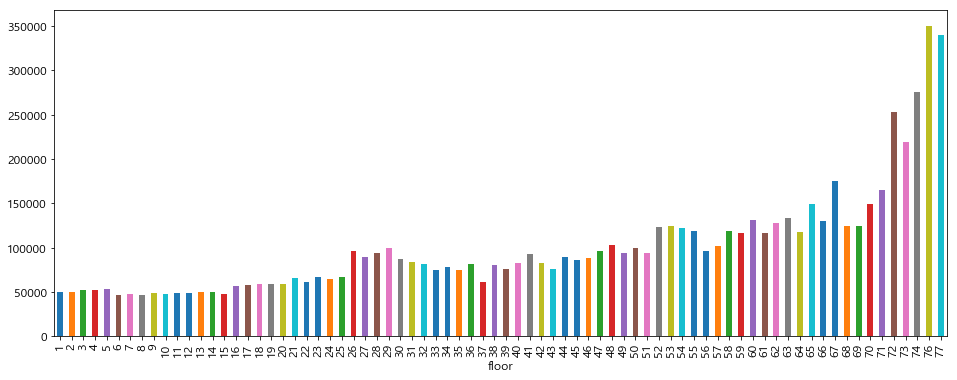

In [17]:
# floor 구간화 필요: 2층과 3층의 가격 차이가 있을까?
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (16, 6)

# 대략적인 구간 확인: 1층 이하, 1 ~ 25층, 26층 ~ 49층, 50층 이상
df.groupby(['floor'])['transaction_real_price'].mean().plot(kind = 'bar')

In [18]:
# 층 수준을 생성한 뒤, 차이를 봄
def floor_level_converter(x):
    if x <= 15:
        return "low"
    elif x <= 25:
        return "middle"
    elif x <= 51:
        return "high"    
    else:
        return "very_high"
    
df['floor_level'] = df['floor'].apply(floor_level_converter)

C:\Users\GilseungAhn\AppData\Roaming\Python\Python36\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


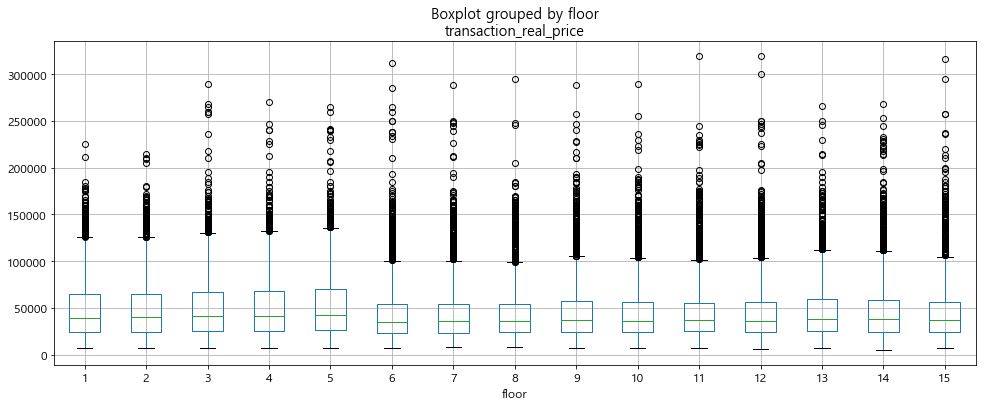

In [19]:
# 저층 그룹에 아파트의 층에 따른 가격 분포 확인 => 층에 따른 차이가 크지 않음
df.loc[df['floor_level'] == 'low'].boxplot(column = 'transaction_real_price', by = 'floor')

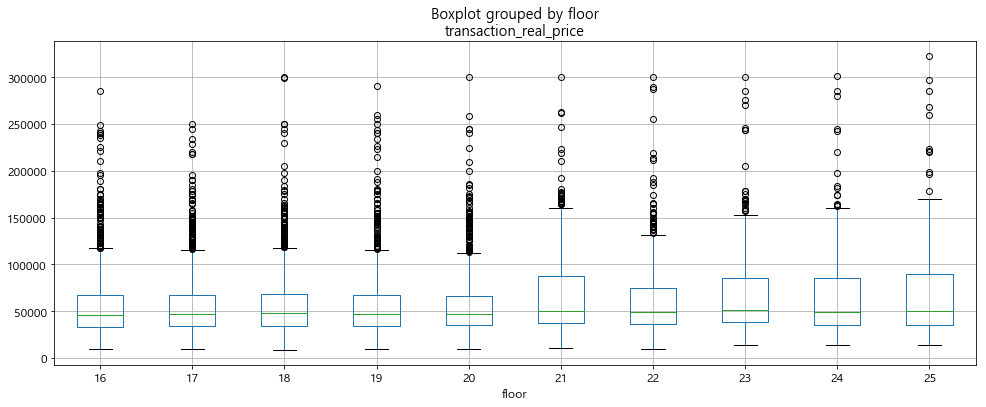

In [20]:
# 중층 그룹에 아파트의 층에 따른 가격 분포 확인 => 층에 따른 차이가 크지 않음
df.loc[df['floor_level'] == 'middle'].boxplot(column = 'transaction_real_price', by = 'floor')

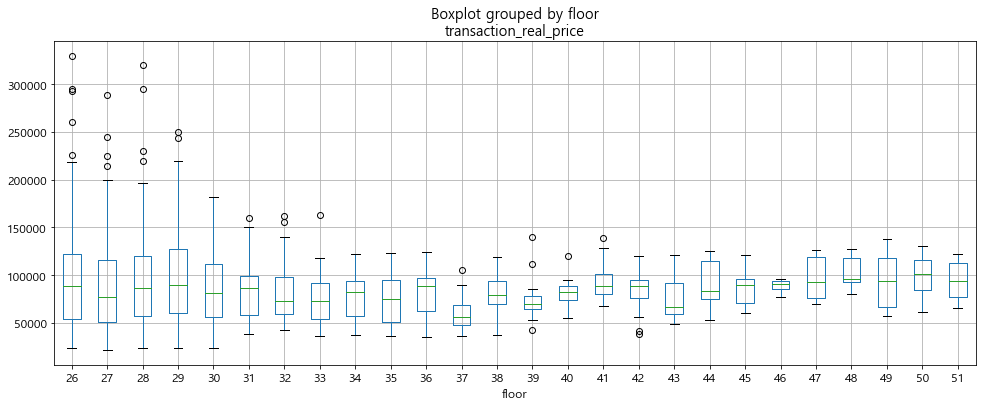

In [21]:
# 고층 그룹에 아파트의 층에 따른 가격 분포 확인 => 층에 따른 차이가 크지 않음
df.loc[df['floor_level'] == 'high'].boxplot(column = 'transaction_real_price', by = 'floor')

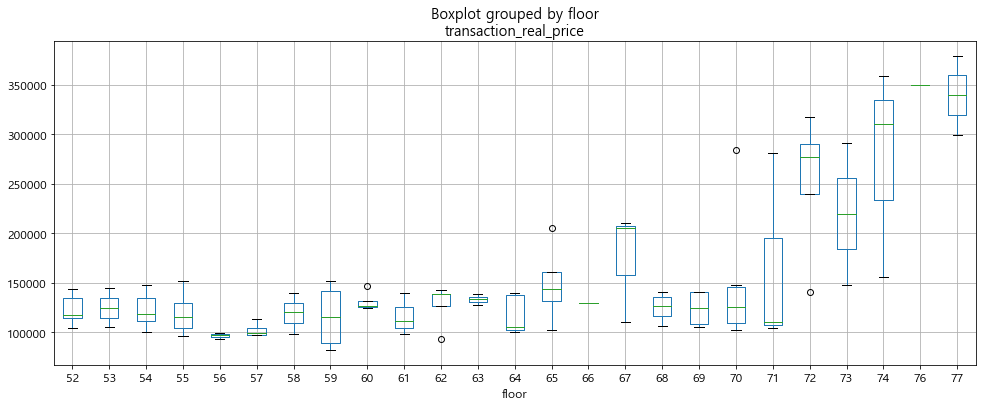

In [22]:
# 초고층 그룹에 아파트의 층에 따른 가격 분포 확인 => 층이 높으면 높을수록 가격이 더 오름 (단, 72층을 기준으로 그런 현상이 두드러짐)
df.loc[df['floor_level'] == 'very_high'].boxplot(column = 'transaction_real_price', by = 'floor')

# 결론: floor_level 변수는 유의하나, floor 변수는 초고층에서만 유의
# 따라서 very high를 세분화하거나, floor_level 변수와 floor 변수를 같이 사용하고 교호작용을 고려할 수 있는 트리 계열의 모델 사용이 적합
# 여기서는 very high를 세분화하기로 결정

In [23]:
# 층 수준을 생성한 뒤, 차이를 봄
def floor_level_converter(x):
    if x <= 15:
        return "low"
    elif x <= 25:
        return "middle"
    elif x <= 51:
        return "high"    
    elif x <= 71: # 새로운 조건 추가
        return "very_high"    
    else:
        return "very_very_high"   

df['floor_level'] = df['floor'].apply(floor_level_converter)
df.drop('floor', axis = 1, inplace = True)

#### 시세 변수 추가

In [24]:
# 구별 전체 평균 시세 부착
mean_price_per_gu = df.groupby(['city', '시군구'], as_index = False)['transaction_real_price'].mean()
mean_price_per_gu.rename({'transaction_real_price':'구별_전체_평균_시세'}, axis = 1, inplace = True)
df = pd.merge(df, mean_price_per_gu, on = ['city', '시군구']) 

In [25]:
# 구별 작년 시세 부착
# price_per_gu_and_year 변수에 직접 수정을 하므로, df가 변경되는 것을 방지하기 위해, df.copy().groupby~를 사용
price_per_gu_and_year = df.copy().groupby(['city', '시군구', 'transaction_year'], as_index = False)['transaction_real_price'].agg(['mean', 'count'])
price_per_gu_and_year = price_per_gu_and_year.reset_index().rename({"mean":"구별_작년_평균_시세", "count":"구별_작년_거래량"}, axis = 1)

price_per_gu_and_year['transaction_year'] += 1 # 작년것을 붙이기 위해, 1을 더함
df = pd.merge(df, price_per_gu_and_year, on = ['city', '시군구', 'transaction_year'], how = 'left') # 작년 기록이 없어서 붙지 않는 것을 방지하기 위해, how = 'left'로 설정
df['구별_작년_거래량'].fillna(0, inplace = True) # 구별 작년 거래 데이터가 없다는 것은, 구별 작년 거래량이 0이라는 이야기이므로 fillna(0)을 수행

In [26]:
# 아파트별 평균 시세 부착
price_per_aid = df.copy().groupby(['apartment_id'], as_index = False)['transaction_real_price'].mean()
price_per_aid.rename({"transaction_real_price":"아파트별_평균가격"}, axis = 1, inplace = True)

df = pd.merge(df, price_per_aid, on = ['apartment_id'])

## 외부 데이터 부착

#### 공원 데이터

In [27]:
park_df = pd.read_csv("park.csv")
park_df.head()

,city,gu,dong,park_name,park_type,park_area,park_exercise_facility,park_entertainment_facility,park_benefit_facility,park_cultural_facitiy,park_facility_other,park_open_year,reference_date
0,부산광역시,남구,대연동,대연공원,근린공원,55227.0,NaN,NaN,NaN,NaN,NaN,1944.0,2018-08-14
1,부산광역시,남구,대연동,당곡공원,역사공원,75465.0,NaN,NaN,NaN,NaN,NaN,1944.0,2018-08-14
2,부산광역시,남구,대연동,대일어린이공원,어린이공원,422.1,NaN,NaN,NaN,NaN,NaN,1965.0,2018-08-14
3,부산광역시,남구,대연동,못골어린이공원,어린이공원,499.8,NaN,NaN,NaN,NaN,NaN,1968.0,2018-08-14
4,부산광역시,남구,용호동,솔밭어린이공원,어린이공원,1500.2,NaN,NaN,NaN,NaN,NaN,1970.0,2018-08-14


In [28]:
# 모든 값을 고려하는 것은 불가능하고, 그리 좋은 접근이 아닌 것으로 보임
park_df['park_exercise_facility'].unique()

array([nan, '게이트볼장', '풋살운동장', '배드민턴장', '야외헬스형운동기구 1개', '"축구장,배드민턴장"',
       '"배드민턴장,테니스장"', '"다목적운동장,농구장,배드민턴장"', '다목적운동장', '"배드민턴장, 게이트볼장"',
       '"테니스장,배드민턴장,체력단련시설"', 'x-game장', '"축구장, 게이트볼장, 테니스장"', '5', '3',
       '7', '12', '10조12종', '0', '5조9종', '10', '11조14종', '6', '8', '9',
       '4', '5조7종', '3조4종', '5조8종', '2조3종', '2', '11', '6조8종', '4조8종',
       '사격장', '철봉 등 6종', '철봉 2', '운동기구 6종',
       '"배드민턴장, 족구장, 게이트볼장, 농구장 반코트"', '테니스장', '"배드민턴장, 지압보도"',
       '헬스형 운동기구 등', '족구장', '"배드민턴장, 체력단련장"',
       '"운동장, 축구장, 농구장, 배드민턴장, 골프연습장, 체력단련장"',
       '"배드민턴장 2개소, 체력단련시설 6개소 36개"',
       '"배드민턴장 1개소, 농구장 1개소, 체력단련시설 3개소 29개"',
       '"배드민턴장 1개소, 농구정 1개소, 체력단련시설 1개소 7개"', '체력단련시설 1개소 3개', '없음',
       '체력단련시설 1개소 4개', '체력단련시설 1개소 6개', '체력단련시설 1개소 2개', '체력단련시설 1개소 7개',
       '체력단련시설 1개소 5개', '체력단련시설 2개소 5개', '체력단련시설 1개소', '배드민턴장 게이트볼장 족구장',
       '"실내배드민턴장, 구민운동장, 다목적체육관, 골프연습장"', '"배드민턴장, 체력단련기구"', '체력단련기구',
       '"농구장, 체력단련기구"', '"농구장, 배드민턴장, 체력단련기구"',
       '"테니스장, 배드민

In [29]:
park_df.columns

Index(['city', 'gu', 'dong', 'park_name', 'park_type', 'park_area',
       'park_exercise_facility', 'park_entertainment_facility',
       'park_benefit_facility', 'park_cultural_facitiy', 'park_facility_other',
       'park_open_year', 'reference_date'],
      dtype='object')

In [30]:
# 따라서 결측을 0으로, 결측이 아니면 1로 변환
facility_cols = ['park_exercise_facility', 'park_entertainment_facility', 'park_benefit_facility', 'park_cultural_facitiy', 'park_facility_other']
for col in facility_cols:
    park_df.loc[park_df[col].notnull(), col] = 1
    park_df.loc[park_df[col].isnull(), col] = 0

In [31]:
# 동별 공원 수 
num_park_per_dong = park_df.groupby(['city', 'gu', 'dong'], as_index = False)['park_name'].count()
num_park_per_dong.rename({"park_name":"공원수"}, axis = 1, inplace = True)

# 동별 공원에 배치된 facilty 수
num_facilty_per_dong = park_df.groupby(['city', 'gu', 'dong'], as_index = False)[facility_cols].sum()
num_facilty_per_dong.head()

,city,gu,dong,park_exercise_facility,park_entertainment_facility,park_benefit_facility,park_cultural_facitiy,park_facility_other
0,부산광역시,강서구,녹산동,1,0,1,0,1
1,부산광역시,강서구,대저1동,1,0,0,0,1
2,부산광역시,강서구,명지동,13,17,4,0,25
3,부산광역시,강서구,송정동,2,0,2,0,2
4,부산광역시,강서구,신호동,2,3,1,0,3


In [32]:
# 공원 데이터 부착
df = pd.merge(df, num_park_per_dong, left_on = ['city', '시군구', 'dong'], right_on = ['city', 'gu', 'dong'], how = 'left')
df['공원수'].fillna(0, inplace = True)
df.drop('gu', axis = 1, inplace = True)

df = pd.merge(df, num_facilty_per_dong, left_on = ['city', '시군구', 'dong'], right_on = ['city', 'gu', 'dong'], how = 'left')
df[facility_cols].fillna(0, inplace = True)
df.drop('gu', axis = 1, inplace = True)

C:\Users\GilseungAhn\AppData\Roaming\Python\Python36\site-packages\pandas\core\frame.py:3035: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


#### 어린이집 데이터

In [33]:
day_care_center_df = pd.read_csv('day_care_center.csv')
day_care_center_df.head()

# 가설: 같은 어린이집이어도 종류가 다르면 아파트 가격에 다르게 영향을 줄 것이다. 가령, 가정 어린이집보단 국공립어린이집이 더 인기가 좋을 것이다.
# 또한, 아이가 있는 부모라면, 어린이집 수와 케어 가능한 아이의 수 등만 보고 아파트 구매를 결정하지, 각 어린이집에 CCTV 개수가 몇개인지 등까진 파악하지 않을 것이다.
# 따라서 구 및 유형별 어린이집 수와 케어 가능한 아이 수만 집계

,city,gu,day_care_name,day_care_type,day_care_baby_num,teacher_num,nursing_room_num,playground_num,CCTV_num,is_commuting_vehicle,reference_date
0,서울특별시,서대문구,가람어린이집,국공립,70,11.0,5.0,1.0,7.0,N,2018-07-31
1,서울특별시,서대문구,가좌제일어린이집,국공립,88,22.0,5.0,2.0,10.0,N,2018-07-31
2,서울특별시,서대문구,경찰청어린이집,직장,90,23.0,6.0,1.0,32.0,N,2018-07-31
3,서울특별시,서대문구,고운햇살어린이집,가정,18,5.0,3.0,0.0,4.0,N,2018-07-31
4,서울특별시,서대문구,고은어린이집,국공립,93,20.0,7.0,2.0,10.0,N,2018-07-31


In [34]:
# 불필요한 변수 제거
day_care_center_df = day_care_center_df[['city', 'gu', 'day_care_type', 'day_care_baby_num']]

In [35]:
dummy_day_care_type = pd.get_dummies(day_care_center_df['day_care_type'], drop_first = False)
dummy_day_care_type = dummy_day_care_type.add_prefix("어린이집유형_")

day_care_center_df = pd.concat([day_care_center_df, dummy_day_care_type], axis = 1)
day_care_center_df.drop('day_care_type', axis = 1, inplace = True)
day_care_center_df.head()

,city,gu,day_care_baby_num,어린이집유형_가정,어린이집유형_국공립,어린이집유형_민간,어린이집유형_법인·단체,어린이집유형_사회복지법인,어린이집유형_직장,어린이집유형_협동
0,서울특별시,서대문구,70,0,1,0,0,0,0,0
1,서울특별시,서대문구,88,0,1,0,0,0,0,0
2,서울특별시,서대문구,90,0,0,0,0,0,1,0
3,서울특별시,서대문구,18,1,0,0,0,0,0,0
4,서울특별시,서대문구,93,0,1,0,0,0,0,0


In [36]:
aggregated_day_care_center_df = day_care_center_df.groupby(['city', 'gu'], as_index = False)[day_care_center_df.columns[2:]].sum()
aggregated_day_care_center_df.head()

,city,gu,day_care_baby_num,어린이집유형_가정,어린이집유형_국공립,어린이집유형_민간,어린이집유형_법인·단체,어린이집유형_사회복지법인,어린이집유형_직장,어린이집유형_협동
0,부산광역시,강서구,5312,71.0,6.0,35.0,0.0,5.0,5.0,1.0
1,부산광역시,금정구,5251,30.0,6.0,58.0,1.0,7.0,3.0,1.0
2,부산광역시,기장군,7689,98.0,13.0,56.0,0.0,5.0,3.0,3.0
3,부산광역시,남구,6676,65.0,12.0,50.0,2.0,6.0,6.0,2.0
4,부산광역시,동구,2214,8.0,9.0,11.0,2.0,2.0,7.0,0.0


In [37]:
# 어린이집 데이터 부착
df = pd.merge(df, aggregated_day_care_center_df, left_on = ['city', '시군구'], right_on = ['city', 'gu'], how = 'left')
df[aggregated_day_care_center_df.columns].fillna(0, inplace = True)
df.drop('gu', axis = 1, inplace = True)

### 모델 학습

In [38]:
X = df.drop(['apartment_id', 'city', 'dong', 'jibun', 'apt', 'transaction_date', 'transaction_real_price', '시군구', 'transaction_year', 'transaction_month'], axis = 1)
Y = df['transaction_real_price']

In [39]:
from sklearn.model_selection import train_test_split
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y)
Train_X.shape # 샘플 대비 특징이 매우 적음 => 큰 부담없이 더미화 가능
# 컬럼 타입이 섞여 있으므로, 트리 계열의 모델이 적절한 것으로 판단됨
# 또한, 샘플이 충분히 많으므로 트리 뿐만 아니라 트리 기반의 앙상블도 적절할 것으로 보임
# Tip. Decision Tree 계열의 모델은 상대적으로 전처리나 탐색의 부담이 제일 적은 모델임

(27012, 22)

In [40]:
# 더미화
from feature_engine.categorical_encoders import OneHotCategoricalEncoder as OHE
dummy_model = OHE(variables = ['floor_level'],
                 drop_last = False)

dummy_model.fit(Train_X)

Train_X = dummy_model.transform(Train_X)
Test_X = dummy_model.transform(Test_X)

In [41]:
# 변수 부착 과정에서 생성된 결측 대체
from sklearn.impute import SimpleImputer as SI
imputer = SI().fit(Train_X)
Train_X = pd.DataFrame(imputer.transform(Train_X), columns = Train_X.columns)
Test_X = pd.DataFrame(imputer.transform(Test_X), columns = Test_X.columns)

In [42]:
from sklearn.model_selection import ParameterGrid
from sklearn.feature_selection import *
from sklearn.ensemble import RandomForestRegressor as RFR
from xgboost import XGBRegressor as XGB
from lightgbm import LGBMRegressor as LGB

In [43]:
model_parameter_dict = dict()
RFR_parameter_grid = ParameterGrid({"max_depth":[3, 4, 5],
                                   "n_estimators": [100, 200]})

XL_parameter_grid = ParameterGrid({"max_depth":[3, 4, 5],
                                  "n_estimators": [100, 200],
                                  "learning_rate": [0.05, 0.1, 0.2]})

model_parameter_dict[RFR] = RFR_parameter_grid
model_parameter_dict[XGB] = XL_parameter_grid
model_parameter_dict[LGB] = XL_parameter_grid

In [44]:
# 출력을 위한 max_iter_num 계산
max_iter_num = len(range(20, 4, -5)) * len(model_parameter_dict) * len(XL_parameter_grid) ** 2
           
from sklearn.metrics import mean_absolute_error as MAE
best_score = 9999999999
iteration_num = 0
for k in range(20, 4, -5): 
    selector = SelectKBest(mutual_info_regression, k = k).fit(Train_X, Train_Y)
    s_Train_X = selector.transform(Train_X)
    s_Test_X = selector.transform(Test_X)

    
    for model_func in model_parameter_dict.keys():
        for parameter in model_parameter_dict[model_func]:
            model = model_func(**parameter).fit(s_Train_X, Train_Y) # Light GBM은 DataFrame의 컬럼 이름에 대한 제약이 있어, ndarray를 입력으로 사용
            pred_Y = model.predict(s_Test_X)
            score = MAE(Test_Y, pred_Y)
            
            if score < best_score:
                print(k, model_func, parameter, score)
                best_score = score
                best_model_func = model_func
                best_parameter = parameter
                best_selector = selector

            iteration_num += 1
            print("iter_num:{}/{}, score: {}, best_score: {}".format(iteration_num, max_iter_num, round(score, 2), round(best_score, 2)))

20 <class 'sklearn.ensemble._forest.RandomForestRegressor'> {'max_depth': 3, 'n_estimators': 100} 8722.581745480249
iter_num:1/3888, score: 8722.58, best_score: 8722.58
iter_num:2/3888, score: 8726.38, best_score: 8722.58
20 <class 'sklearn.ensemble._forest.RandomForestRegressor'> {'max_depth': 4, 'n_estimators': 100} 7197.470197760451
iter_num:3/3888, score: 7197.47, best_score: 7197.47
iter_num:4/3888, score: 7199.27, best_score: 7197.47
20 <class 'sklearn.ensemble._forest.RandomForestRegressor'> {'max_depth': 5, 'n_estimators': 100} 5949.720873045102
iter_num:5/3888, score: 5949.72, best_score: 5949.72
20 <class 'sklearn.ensemble._forest.RandomForestRegressor'> {'max_depth': 5, 'n_estimators': 200} 5894.0812506547745
iter_num:6/3888, score: 5894.08, best_score: 5894.08
[19:20:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
20 <class 'xgboost.sklearn.XGBRegressor'> {'learning_

In [45]:
final_X = pd.concat([Train_X, Test_X], axis = 0, ignore_index = True)
final_Y = pd.concat([Train_Y, Test_Y], axis = 0, ignore_index = True)

final_model = best_model_func(**best_parameter).fit(best_selector.transform(final_X), final_Y)

[19:27:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


### 파이프라인 구축

In [46]:
def pipeline(new_data, ref_df, model, selector, mean_price_per_gu, num_park_per_dong, num_facilty_per_dong, aggregated_day_care_center_df, imputer, dummy_model):
    ## 변수 변환 및 부착
    new_data['dong'] = new_data['dong'].str.split(' ', expand = True).iloc[:, 0] # dong에 리가 붙어있으면 제거
    
    new_data = pd.merge(new_data, ref_df, left_on = ['city', 'dong'], right_on = ['시도', '법정동']) # 시군구 부착 
    
    new_data.drop(['시도', '법정동', 'transaction_id', 'addr_kr'], axis = 1, inplace = True) # 불필요한 변수 제거
    
    # age 변수 부착
    new_data['age'] = 2018 - new_data['year_of_completion']
    new_data.drop('year_of_completion', axis = 1, inplace = True)    
    
    # 거래 년월 부착
    new_data['transaction_year_month'] = new_data['transaction_year_month'].astype(str)
    new_data['transaction_year'] = new_data['transaction_year_month'].str[:4].astype(int)
    new_data['transaction_month'] = new_data['transaction_year_month'].str[4:].astype(int)
    new_data.drop('transaction_year_month', axis = 1, inplace = True)   

    # Seoul 생성
    new_data['Seoul'] = (new_data['city'] == "서울특별시").astype(int)    
    
    # floor_level 변수 생성
    new_data['floor_level'] = new_data['floor'].apply(floor_level_converter)
    new_data.drop('floor', axis = 1, inplace = True)    
    
    # 시세 관련 변수 추가
    new_data = pd.merge(new_data, mean_price_per_gu, on = ['city', '시군구'])
    new_data = pd.merge(new_data, price_per_gu_and_year, on = ['city', '시군구', 'transaction_year'], how = 'left')
    new_data['구별_작년_거래량'].fillna(0, inplace = True) # 구별 작년 거래 데이터가 없다는 것은, 구별 작년 거래량이 0이라는 이야기이므로 fillna(0)을 수행
           
    new_data = pd.merge(new_data, price_per_aid, on = ['apartment_id'], how = 'left')
    
    
    # 공원 데이터 부착
    new_data = pd.merge(new_data, num_park_per_dong, left_on = ['city', '시군구', 'dong'], right_on = ['city', 'gu', 'dong'], how = 'left')
    new_data['공원수'].fillna(0, inplace = True)
    new_data.drop('gu', axis = 1, inplace = True)

    new_data = pd.merge(new_data, num_facilty_per_dong, left_on = ['city', '시군구', 'dong'], right_on = ['city', 'gu', 'dong'], how = 'left')
    
    facility_cols = ['park_exercise_facility', 'park_entertainment_facility', 'park_benefit_facility', 'park_cultural_facitiy', 'park_facility_other']
    new_data[facility_cols].fillna(0, inplace = True)
    new_data.drop('gu', axis = 1, inplace = True)    
    
    # 어린이집 데이터 부착
    new_data = pd.merge(new_data, aggregated_day_care_center_df, left_on = ['city', '시군구'], right_on = ['city', 'gu'], how = 'left')
    new_data[aggregated_day_care_center_df.columns].fillna(0, inplace = True)
    new_data.drop('gu', axis = 1, inplace = True)
    
    # 특징 추출 ('transaction_real_price'는 drop 대상에서 제외)
    X = new_data.drop(['apartment_id', 'city', 'dong', 'jibun', 'apt', 'transaction_date', '시군구', 'transaction_year', 'transaction_month'], axis = 1)
    
    # 더미화
    X = dummy_model.transform(X)
    
    # 결측 대체
    X = imputer.transform(X)
            
    # 특징 선택
    X = selector.transform(X)
    
    return model.predict(X)

In [47]:
import pickle
pipeline_element = {"ref_df": ref_df,
                   "model":final_model,
                   "selector":best_selector,
                   "mean_price_per_gu":mean_price_per_gu,
                   "num_park_per_dong":num_park_per_dong,
                   "num_facilty_per_dong":num_facilty_per_dong,
                   "aggregated_day_care_center_df":aggregated_day_care_center_df,
                   "imputer":imputer,
                   "dummy_model":dummy_model,
                   "pipeline":pipeline}

with open("아파트실거래가예측모델.pckl", "wb") as f:
    pickle.dump(pipeline_element, f)

In [48]:
with open("아파트실거래가예측모델.pckl", "rb") as f:
    pipeline_element = pickle.load(f)

ref_df = pipeline_element["ref_df"]
model = pipeline_element["model"]
selector = pipeline_element["selector"]                 
mean_price_per_gu = pipeline_element["mean_price_per_gu"]
num_park_per_dong = pipeline_element["num_park_per_dong"]
num_facilty_per_dong = pipeline_element["num_facilty_per_dong"]
aggregated_day_care_center_df = pipeline_element["aggregated_day_care_center_df"]
imputer = pipeline_element["imputer"]
dummy_model = pipeline_element["dummy_model"]
pipeline = pipeline_element["pipeline"]

[19:27:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [49]:
test_df = pd.read_csv("sampled_test.csv")
test_df.head()

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor
0,1197195,4018,서울특별시,암사동,414-2,롯데캐슬퍼스트,암사동 414-2 롯데캐슬퍼스트,102.34,2008,201712,21~31,9
1,1190777,520,서울특별시,가락동,140,가락(1차)쌍용아파트,가락동 140 가락(1차)쌍용아파트,59.92,1997,201712,21~31,15
2,1197165,6467,서울특별시,암사동,509,선사현대아파트,암사동 509 선사현대아파트,59.64,2000,201712,21~31,6
3,1179572,731,서울특별시,개포동,189,개포주공 4단지,개포동 189 개포주공 4단지,50.67,1982,201707,1~10,3
4,1131476,5950,서울특별시,상계동,626,상계주공14(고층),상계동 626 상계주공14(고층),90.94,1989,201712,11~20,6


In [50]:
output = pipeline(test_df, ref_df, model, selector, mean_price_per_gu, num_park_per_dong, num_facilty_per_dong, aggregated_day_care_center_df, imputer, dummy_model)
result = pd.Series(output, index = test_df['transaction_id'])
result

C:\Users\GilseungAhn\AppData\Roaming\Python\Python36\site-packages\pandas\core\frame.py:3035: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


transaction_id
1197195     77147.906250
1190777     46227.941406
1197165     73025.078125
1179572     80541.601562
1131476     68557.062500
1101274     80541.601562
1190516     46227.941406
1094600     91324.171875
1152085     46227.941406
1115383     58131.761719
1205319     59395.871094
1179598     51689.699219
1233216     80541.601562
1218957     58788.285156
1190442     68557.062500
1131387     45206.621094
1182521     72251.757812
1175579     41782.914062
1190449     85825.773438
1223113     41782.914062
1182642     58977.539062
1131284     54140.132812
1179563     54140.132812
1190344    102701.375000
1197197     54140.132812
1190880     65937.742188
1117471     65937.742188
1225900     65937.742188
1233198     65937.742188
1197178     54140.132812
               ...      
1190722     30065.269531
1205384     30065.269531
1190470     61284.703125
1131259     64853.863281
1190511     42799.925781
1170478     45223.945312
1179675     53955.984375
1131429     84859.546875
1101322   